### Extract Job Info

In [1]:
import pandas as pd
import chardet
import json
from loguru import logger

In [2]:
encoding = chardet.detect(open('job_data.csv', 'rb').read())
df = pd.read_csv('job_data.csv',
                 encoding=encoding['encoding'])
job_list = list(df['KNOW직업명'].values)

흐름.
1. 직업명 들어옴.
2. 5개의 노드로 분기됨 (병렬실행)
3. 각 노드에서는 해당되는 검색을 수행후 답변생성
4. 답변취합
5. 적절성 판단.
6. 부적절한 내용은 해당 노드만 재 분기하여 검색.

In [28]:
from langchain_community.document_loaders import AsyncHtmlLoader
from langchain_community.document_transformers import Html2TextTransformer
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langgraph.graph import START, MessagesState, StateGraph, END
from langchain.tools import tool
from bs4 import BeautifulSoup
from duckduckgo_search import DDGS
from langchain_community.tools.tavily_search import TavilySearchResults
from models.model import LLM

In [29]:
import os
import dotenv
dotenv.load_dotenv()
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

In [30]:
@tool
def DDGS_search(query) -> list:
    """Look up things online."""
    searches = DDGS().text(keywords=query, max_results=5)
    return searches

@tool
def Tavily_search(query) -> list:
    """Look up things online."""
    searches = TavilySearchResults(max_results=3).invoke({"query":query})
    return searches

@tool
def extract_content(link: str) -> str:
    """Extract content from a given link."""
    loader = AsyncHtmlLoader(link)
    docs = loader.load()
    html2text = Html2TextTransformer()
    docs_transformed = html2text.transform_documents(docs, metadata_type="html")
    detailed_content = docs_transformed[0].page_content
    return detailed_content

In [21]:
# state["messages"] = [SystemMessage(content="당신은 정보 검색 전문가입니다."), 
                    #  HumanMessage(content=f"{state['query']}에 적합한 내용만을 추출하세요. 최대한 짧고 간결하게 핵심내용만 추출합니다.")]

In [40]:
def Node__search_todo(state):
    logger.info("Node__search_todo")
    query = state['messages'][0].content + " " + "하는일"
    state["query"] = query
    searches = Tavily_search.invoke({"query":query})
    print("searches :",searches)
    state["searches"] = searches
    print("result state todo:",state) 
    return state

def Node__search_salary(state):
    logger.info("Node__search_salary")
    query = state['messages'][0].content + " " + "연봉, 임금정보"
    state["query"] = query
    searches = Tavily_search.invoke({"query":query})
    print("searches :",searches)
    state["searches"] = searches
    print("result state salary:",state)
    return state

def Node__extract_content(state):
    logger.info("Node__extract_content")
    print("state :",state)
    for idx,search in enumerate(state['searches']):
        logger.warning(f"search_{idx} : {search['href']}")
        detailed_content = extract_content(search['href'])
        msg = [HumanMessage(content=f""" \n 
                            참고내용에서 사용자 요청문에 적합한 내용만을 추출하세요. 최대한 짧고 간결하게 핵심내용만 추출합니다.
                            
                            사용자 요청문 : {state["query"]}
                            
                            참고내용 :
                            {detailed_content} 
                            Formulate an improved question: """)]
        response = LLM.invoke(msg)
        state["searches"][idx]["detailed_content"] = response.content
    return state

def call_model(state: MessagesState):
    response = LLM.invoke(state["messages"])
    return {"messages": response}

In [41]:
# def extract_content_node(state):
#     return {"detailed_content": extract_content(state)}

# searches = search.invoke({"query":query,
#                           "subquery":"하는일"})

# detailed_content = extract_content.invoke({"link":searches[0]['href']})

### Set LangGraph

In [42]:
# Define a new graph
workflow = StateGraph(state_schema=MessagesState)

# Set Nodes
workflow.add_node("Node__search_todo", Node__search_todo)
workflow.add_node("Node__search_salary", Node__search_salary)
workflow.add_node("Node__extract_content", Node__extract_content)
workflow.add_node("model", call_model)

# Set Edge
workflow.add_edge(START, "Node__search_todo")
workflow.add_edge(START, "Node__search_salary")
workflow.add_edge("Node__search_todo", "Node__extract_content")
workflow.add_edge("Node__search_salary", "Node__extract_content")
workflow.add_edge("Node__extract_content", "model")
workflow.add_edge("model", END)

# Set Memory 
# graph = workflow.compile(checkpointer=memory)
graph = workflow.compile()

# Set Config
config = {"configurable": {"thread_id": "abc124"}}

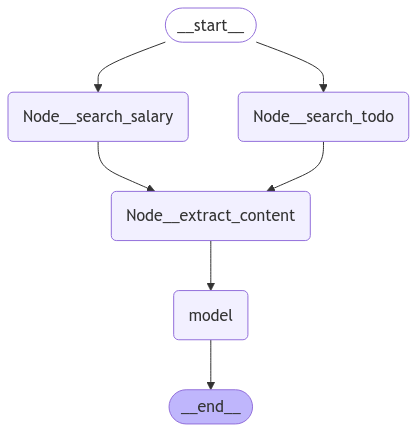

In [43]:
from IPython.display import Image, display
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [44]:
result = graph.invoke({"messages":job_list[0]}, config)

2024-12-01 22:21:36.779 | INFO     | __main__:Node__search_todo:2 - Node__search_todo
2024-12-01 22:21:36.779 | INFO     | __main__:Node__search_salary:12 - Node__search_salary
2024-12-01 22:21:39.409 | INFO     | __main__:Node__extract_content:22 - Node__extract_content


searches : [{'url': 'https://careermomentum.net/속기사-연봉-및-전망', 'content': '속기사 연봉 및 전망 Home » 직업 정보 » 속기사 연봉 및 전망 속기사 연봉 및 전망 이 글에서는 속기사의 연봉 및 전망, 업무 환경과 하는 일 그리고 속기사가 되는 법 등에 대해서 알아보도록 하겠습니다. 일반적으로 속기사 양성학원에서 속기사 자격증을 취득하면서 업무능력을 익히는 편이며, 자격증을 취득하면 국회, 법원, 검찰과 경찰 등 기록을 중요시하는 기관에서 일할 수 있습니다. 속기사의 연봉 경찰청에서 일하는 속기사의 경우 보통 월급은 200만원 수준이며 한 달에 보통 20~ 30건 정도의 사건을 처리한다고 합니다. 건 당 인센티브가 별도로 주어지기 때문에 월급도 인센티브에 따라 조금씩 다른 것으로 알려져 있습니다. 법원, 검찰, 경찰 등에서는 영상녹화제를 실시하면서 속기사의 필요성이 높아지고 있습니다. 미국 인공지능 관련 직업 연봉 및 추천 AI 기업 5곳 취업과 연봉 및 직업에 대한 정보를 제공합니다.'}, {'url': 'https://moneypicker.kr/속기사-연봉-월급-채용-전망/', 'content': '속기사 연봉/월급/채용/전망 총정리(2024년) 속기사 연봉/월급/채용/전망 총정리(2024년) 속기사 연봉 및 월급과 채용정보(되는 법), 앞으로의 전망 등에 대해서 알아보도록 하겠습니다. 속기사 되는법(채용) 속기사 연봉 및 월급 속기사 전망 속기사 되는법(채용) 속기사 채용 정보는 다음과 같습니다. 소리자바 아카데미 속기사 채용 공고 속기사 연봉 및 월급 속기사 연봉과 월급은 위와 같습니다. 속기사 전망 법원, 검찰, 경찰 등에서는 영상녹화제를 도입하고 있는데 이로 인해 재판이나 조사 과정에서 발언 내용을 기록하는 속기사의 역할이 더 중요해지고 있으며 TV 방송에서 청각장애인들이 시청할 수 있도록 자막을 제공하는 업무도 속기사의 중요한 업무 영역 중 하나로 자리 잡고 있어 이를 통해 속기사의 고용이

KeyError: 'searches'

In [26]:
def extract_content(link):
    """
        Des:
            주어진 링크에 대한 내용 추출하는 함수
    """
    loader = AsyncHtmlLoader(link)
    docs = loader.load()
    html2text = Html2TextTransformer()
    docs_transformed = html2text.transform_documents(docs,metadata_type="html")
    desc = docs_transformed[0].metadata.get('description',"")
    detailed_content = docs_transformed[0].page_content
    return desc,detailed_content

프롬프트

In [26]:
# Input
BASE_PROMPT = """
발전소 관련 데이터를 생성하고 있습니다.
용어에 대한 정의를 나타내는 문장을 생성하세요.

예를 들어, 아래와 같은 형식으로 주요 용어를 정의할 수 있습니다:
발전소(Power Plant)는 전기를 생산하기 위해 다양한 에너지원(화석 연료, 원자력, 재생 가능 에너지 등)을 이용하여 전력을 생성하고 이를 전력망에 공급하는 시설을 말한다. 발전소는 사용하는 에너지원과 발전 방식에 따라 여러 종류로 구분된다.

다음 지시사항을 따르세요.
1. 한국어와 영어를 제외한 언어는 사용하지 않습니다.
2. 정확히 아는 정보에 대해서는 자세히 설명합니다.
3. 생성해야할 용어에 대한 정보는 [용어 정보]를 참고하세요.

[용어 정보]
{query}

생성 문장 :
"""

데이터 생성 수행

In [ ]:
SAVE_PATH = os.path.join(PREPROCESSED_PATH,'PowerPlant_Glossary.json')

try:
    dataset = json.load(open(SAVE_PATH, 'r', encoding='utf-8'))
except:
    dataset = []

for idx, query in enumerate(tqdm(queries)):
    PROMPT = BASE_PROMPT.format(query=query[1])
    INPUT_MESSAGES = [SystemMessage(content="당신은 데이터 생성 어시스턴트입니다."), 
                      HumanMessage(PROMPT)]
    try:
        output = graph.invoke({"messages":INPUT_MESSAGES}, config)["messages"][-1].content
        dataset.append({"name": query[0],
                        "info": query[1],
                        "prompt": PROMPT,
                        "response": output})
        with open(SAVE_PATH, 'w', encoding='utf-8') as file:
            json.dump(dataset, file, ensure_ascii=False, indent=4)
    except Exception as e:
        with open(f'error_log.txt', 'a', encoding='utf-8') as file:
            file.write(f"{idx} : {query[1]} : {e}\n")
        continue

프롬프트 생성

In [77]:
# Input
BASE_PROMPT = """
발전소 관련 데이터를 생성하고 있습니다.
다음 답변에 대한 요청문을 생성하세요.

예를 들어 주어진 정보가 있을때, 생성된 요청문은 아래와 같습니다.

# 주어진 정보
태양광발전 판넬(Photovoltaic Panel)은 태양광을 전기 에너지로 변환하는 태양전지 모듈들을 기계적으로 결합하여 널판 형태로 만든 집합체를 말한다. 이 판넬은 어레이 또는 하위의 소어레이에 설치 가능한 단위로 설계되어 미리 조립하고 결선하여 함께 결합된 형태로 제공되며, 현장에서 쉽게 조립할 수 있도록 설계되어 있다.

# 생성된 요청문
태양광발전시스템에 대해 설명해주세요.

다음 지시사항을 따르세요.
1. 한국어와 영어를 제외한 언어는 사용하지 않습니다.
2. 요청문은 간결한 문장 1개만 사용하세요.
3. 요청문은 용어에 대한 정의를 묻는 질문만 사용합니다.
4. 요청문은 다양한 형태를 사용할 수 있습니다. 예를들어, 아래중에 한가지를 사용할 수 있습니다.
    4.1 태양광발전시스템에 대해 설명해주세요.
    4.2 태양광발전시스템이 뭐죠?
    4.3 태양광발전시스템에 대해 알려주실래요?
    4.4 태양광발전시스템이 뭔가요?
    4.5 태양광발전시스템에 대해 알려주세요.

[주어진 정보]
{response}

생성된 요청문 :
"""

In [ ]:
PREVIOUS_SAVE_PATH = os.path.join(PREPROCESSED_PATH,'PowerPlant_Glossary.json')
NEW_SAVE_PATH = os.path.join(PREPROCESSED_PATH,'PowerPlant_Glossary_ver2.json')
dataset = json.load(open(PREVIOUS_SAVE_PATH, 'r', encoding='utf-8'))

try:
    new_dataset = json.load(open(NEW_SAVE_PATH, 'r', encoding='utf-8'))
except:
    new_dataset = []

for idx, query in enumerate(tqdm(dataset)):
    PROMPT = BASE_PROMPT.format(response=query['response'])
    INPUT_MESSAGES = [SystemMessage(content="당신은 데이터 생성 어시스턴트입니다."), 
                      HumanMessage(PROMPT)]
    try:
        output = graph.invoke({"messages":INPUT_MESSAGES}, config)["messages"][-1].content
        new_dataset.append({"name": query['name'],
                            "info": query['info'],
                            "prompt_for_instruction": PROMPT,
                            "prompt_for_response": query['prompt'],
                            "instruction": output,
                            "response": query['response']})
        with open(NEW_SAVE_PATH, 'w', encoding='utf-8') as file:
            json.dump(new_dataset, file, ensure_ascii=False, indent=4)
    except Exception as e:
        with open(f'error_log.txt', 'a', encoding='utf-8') as file:
            file.write(f"{idx} : {query[1]} : {e}\n")
        continue